![](https://media.discordapp.net/attachments/1047111061314220033/1176542563633737728/image.png)

Approche contre factuelle : quoi faire pour que l'exemple ne soit plus un outliers 

base de référence : dataset classic

# Génération de bases de données

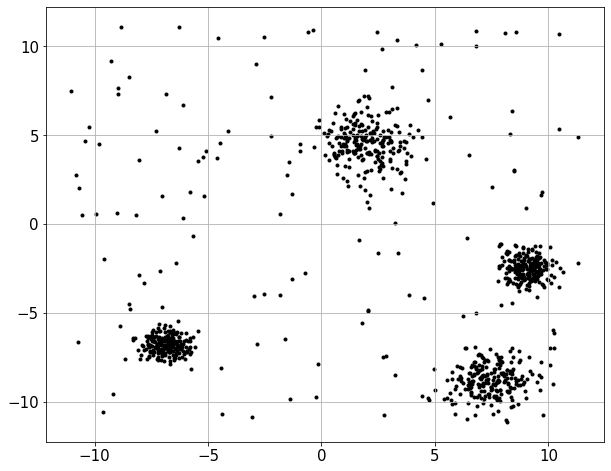

In [45]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import warnings
import dice_ml
from sklearn.inspection import DecisionBoundaryDisplay
import pandas as pd

# Seed for reproducibility
np.random.seed(0)

def create_similar_dataset(n_samples=1000, n_centers=4, cluster_std=0.6, outliers_fraction=0.15, random_state=42, ):
    n_outliers = int(outliers_fraction * n_samples)
    n_inliers = n_samples - n_outliers

    X, y = make_blobs(
        n_samples=n_inliers, centers=n_centers, cluster_std=cluster_std, random_state=random_state
    )
    # X = X[:, ::-1]
    X = np.concatenate([X, np.random.uniform(low=X.min(), high=X.max(), size=(n_outliers, 2))], axis=0)
    y = np.concatenate([np.ones((2 * n_samples), dtype=int), -np.ones((n_outliers), dtype=int)])
    return X, y

# Create the dataset
X_similar, _ = create_similar_dataset(cluster_std=[0.6, 1, 0.5, 0.9])
X_similar = X_similar[:, ::-1]
# Visualize the dataset
plt.figure(figsize=(10, 8))
plt.scatter(X_similar[:, 0], X_similar[:, 1], c='black', marker='.')
plt.grid(True)
plt.show()

# Détéction des outliers

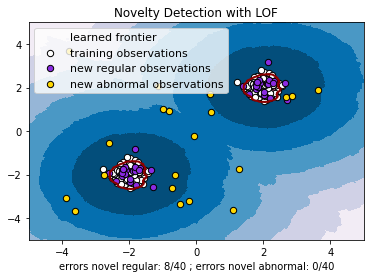

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate normal (not abnormal) training observations
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate new normal (not abnormal) observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)
# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the learned frontier, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [a.collections[0], b1, b2, c],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.xlabel(
    "errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_test, n_error_outliers)
)
plt.show()

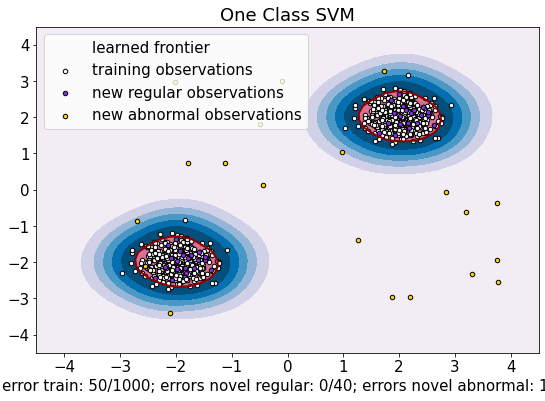

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

font = {"weight": "normal", "size": 15}

matplotlib.rc("font", **font)

random_state = 42
rng = np.random.RandomState(random_state)

# Generate train data
X = 0.3 * rng.randn(500, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

xx, yy = np.meshgrid(np.linspace(-4.5, 4.5, 50), np.linspace(-4.5, 4.5, 50))

# OCSVM hyperparameters
nu = 0.05
gamma = 2.0

# Fit the One-Class SVM
clf = OneClassSVM(gamma=gamma, kernel="rbf", nu=nu)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot the level sets of the decision function
plt.figure(figsize=(9, 6))
plt.title("One Class SVM")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

s = 20
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")
plt.axis("tight")
plt.xlim((-4.5, 4.5))
plt.ylim((-4.5, 4.5))
plt.legend(
    [a.collections[0], b1, b2, c],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
)
plt.xlabel(
    "error train: %d/%d; errors novel regular: %d/%d; errors novel abnormal: %d/%d"
    % (
        n_error_train,
        X_train.shape[0],
        n_error_test,
        X_test.shape[0],
        n_error_outliers,
        X_outliers.shape[0],
    )
)
plt.show()

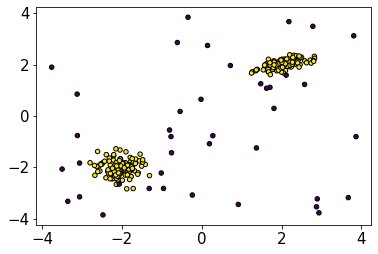

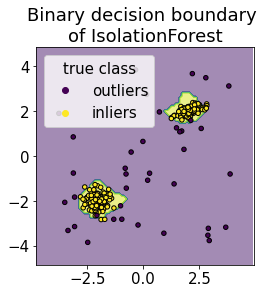

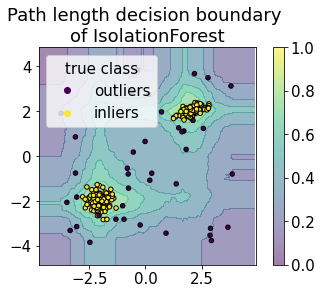

In [32]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


n_samples, n_outliers = 120, 40
rng = np.random.RandomState(0)
covariance = np.array([[0.5, -0.1], [0.7, 0.4]])
cluster_1 = 0.4 * rng.randn(n_samples, 2) @ covariance + np.array([2, 2])  # general
cluster_2 = 0.3 * rng.randn(n_samples, 2) + np.array([-2, -2])  # spherical
outliers = rng.uniform(low=-4, high=4, size=(n_outliers, 2))

X = np.concatenate([cluster_1, cluster_2, outliers])
y = np.concatenate(
    [np.ones((2 * n_samples), dtype=int), -np.ones((n_outliers), dtype=int)]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
handles, labels = scatter.legend_elements()

clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(X_train)


from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
plt.show()

mais pourquoi me prédit il comme donnée exceptionnelle
- explications naives : on a un prédicteur : lof, svm ou arbre clf qui étant donné X exception ou pas... => on prend les méthodes qu'on a déjà vu pour expliquer les classifieurs. souligne les modifications mineures pour qu'il ne soit plus prédit comme étant une prédiction. est-ce que ça nous permet nous meme de voir . si donné prédite avec lof très élevée = donnée très exceptionnelle : on peut s'attendre à ce que les moduifications soient plus importantes pour un lof moyen. corrélation entre valeur du lof et ampleur de la modification suggérée par le contrefactuelle
    - foret d'isolation : pas même principe donc pas forcémpent de corrélation, donc raison pas la même que celle apportée par rapport à un lof, méthodes spécifiques pour les forets DIFFI (dans le cours)
- lime : quels attributs sont importants 
    - 

ValueError: ValueError: 'c' argument has 40 elements, which is inconsistent with 'x' and 'y' with size 20.

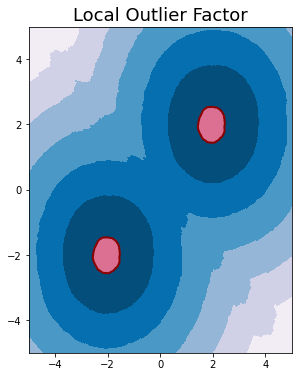

In [25]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, novelty=True, contamination=outliers_fraction),
    ),
    ("One-Class SVM", OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
]

# Define datasets
# X, y = create_similar_dataset(n_samples=n_samples, outliers_fraction=outliers_fraction)
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 10, 6))

plot_num = 1
rng = np.random.RandomState(42)


outliers_dict = {}
for name, algorithm in anomaly_algorithms:
    algorithm.fit(X_train)
    
    plt.subplot(1, len(anomaly_algorithms), plot_num)
    plt.title(name, size=18)

    # fit the data and tag outliers
    # if name == "Local Outlier Factor":
    #     y = algorithm.predict(X_test)
    # else:
    y = algorithm.predict(X_test)
    outliers_dict[name] = y

    # plot the levels lines and the points
    if name == "Local Outlier Factor":  # LOF does not implement predict
        Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
        a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
        plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y + 1) // 2])
    else:
        disp = DecisionBoundaryDisplay.from_estimator(
            algorithm,
            X,
            response_method="decision_function",
            alpha=0.5,
        )
        disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
        plt.colorbar(disp.ax_.collections[1])
        ...


    # visualize(ax=plt.gca())
    plot_num += 1

plt.show()

# Explication naïve

## Contrefactuel sur les forêts d'isolation

### DiceML

In [40]:
def visualize(
    X, # les données
    # y=None,
    clf,
    backend="sklearn",
    n=10,
    eta=2,
    n_gs=100,
    ax=None,
):
    def plot_boundaries(X, y, ax, clf):
        """ "Plot the data and the decision boundary resulting from a classifier."""
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
        # Plot the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
    
    # if not clf and not y:
    #     y = clf.fit_predict(X)
    y = clf.fit_predict(X)
    
    df = pd.DataFrame(X, columns=["X", "Y"])
    df["Target"] = y

    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["X", "Y"],
        outcome_name="Target",
    )
    model = dice_ml.Model(model=clf, backend=backend)
    if backend == "sklearn":
        explainer = dice_ml.Dice(data, model, method="random")
    else:
        explainer = dice_ml.Dice(data, model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["X", "Y"]],
        total_CFs=4,
        desired_class="opposite",
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.1,
    )

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    first_outliers = np.argwhere(y==1)[0]
    ax.scatter(
        df.loc[first_outliers, "X"],
        df.loc[first_outliers, "Y"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)

    return enemy_df

class CustomIsolationForest(IsolationForest):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def predict_proba(self, X):
        return super().score_samples(X)

clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.predict_proba = lambda x: clf.score_samples(x)
visualize(X_similar, clf=clf)
# for name, clf in anomaly_algorithms:
    # fig = plt.figure(figsize=(27, 6))
    # for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
    #     X, y = dataset
    #     clf = clf.fit(X, y)
    #     ax = fig.add_subplot(1, len(datasets), i + 1)
    #     ax.set_title(name)
    #     visualize(X, y, clf, "sklearn", ax=ax)
    # fig.tight_layout()

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


UserConfigValidationException: UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.

### Growing Sphere

In [88]:
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

#   ┌────────────────────────────────────────────────────────────────────────┐
#   │ Plot                                                                   │
#   └────────────────────────────────────────────────────────────────────────┘


def plot_boundaries(X, y, ax, clf):
    """Plot the data and the decision boundary resulting from a classifier."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def plot_obs_and_enemy(obs, enemy, ax, colors=["red", "orange"]):
    """
    Plot the observation to interprete and the enemy returned by the growing sphere
    generation algorithm.
    """
    ax.scatter(*enemy, c=colors[0])
    ax.scatter(*obs, c=colors[1])


#    ┌────────────────────────────────────────────────────────────────────────┐
#    │ Growing Spheres                                                        │
#    └────────────────────────────────────────────────────────────────────────┘


class GrowingSpheres:
    """
    obs_to_interprete : x, une observation à interpréter
    clf : classifieur binaire
    eta : hyperparamètre
    n : nombre de points que l'on génère
    """

    def __init__(self, clf, eta, n):
        self.clf = clf
        self.eta = eta
        self.n = n

    def generate_spherical_layer(self, a0, a1) -> np.ndarray:
        """
        Generate a spherical layer with the specified parameters.

        Parameters:
            a0 (float): Inner radius of the spherical layer.
            a1 (float): Outer radius of the spherical layer.

        Returns:
            np.ndarray: A numpy array representing the generated spherical layer.
        """

        def norm(v):
            return np.linalg.norm(v, ord=2, axis=1)

        z = np.random.normal(0, 1, (self.n, self.d))
        u = np.random.uniform(a0**self.d, a1**self.d, size=self.n)
        u = u ** (1 / self.d)
        z = np.array([a * b / c for a, b, c in zip(z, u, norm(z))])  # z = z * u / norm(z)
        return self.obs_to_interprete + z

    def find_enemy(self, spherical_layer):
        """
        Find and update enemy information in a spherical layer.

        Parameters:
            spherical_layer (numpy.ndarray): A 2D numpy array representing the spherical
            layer data.

        Returns:
            bool: True if enemies are found in the spherical layer, False otherwise.
        """
        pred = self.clf.predict(spherical_layer)
        self.enemies = spherical_layer[pred != self.obs_predict]
        return (pred != self.obs_predict).any()

    def predict(self, obs_to_interprete):
        self.obs_to_interprete = obs_to_interprete.reshape(1, -1)
        self.obs_predict = self.clf.predict(self.obs_to_interprete)
        self.d = self.obs_to_interprete.shape[1]

        enemy = self.generation()
        return enemy, self.feature_selection(enemy)

    def generation(self):
        self.iter = 0
        spherical_layer = self.generate_spherical_layer(0, 1)
        while self.find_enemy(spherical_layer):
            self.eta /= 2
            spherical_layer = self.generate_spherical_layer(0, self.eta)
            self.iter += 1
        a0 = self.eta
        a1 = 2 * self.eta
        while not self.find_enemy(spherical_layer):
            spherical_layer = self.generate_spherical_layer(a0, a1)
            a0 = a1
            a1 = a1 + self.eta
            self.iter += 1
        return self.enemies[np.linalg.norm(self.enemies - self.obs_to_interprete).argmin()]

    def feature_selection(self, counterfactual):
        move_sorted = sorted(
            enumerate(abs(counterfactual - self.obs_to_interprete.flatten())),
            key=lambda x: x[1],
        )
        move_sorted = [x[0] for x in move_sorted if x[1] > 0.0]
        out = counterfactual.copy()
        reduced = 0

        for k in move_sorted:
            new_enn = out.copy()
            new_enn[k] = self.obs_to_interprete.flatten()[k]

            if self.clf.predict(new_enn.reshape(1, -1)) == self.obs_predict:  # il faut mettre argmax pour multiclasse
                out[k] = new_enn[k]
                reduced += 1

        return out

def find_enemies(dataset, clf, obs_to_interpret, n=10, eta=2, n_gs=100):
    X, y = dataset
    clf.fit(X, y)

    enemies = []
    enemies_fs = []
    for _ in range(n):
        gs = GrowingSpheres(clf, eta, n_gs)
        enemy, enemy_fs = gs.predict(obs_to_interpret)
        enemies.append(enemy)
        enemies_fs.append(enemy_fs)

    return enemies, enemies_fs


def visualize(dataset, clf, obs_to_interprete, n=10, eta=2, n_gs=100, ax=None):
    X, y = dataset

    enemies, enemies_fs = find_enemies(dataset, clf, obs_to_interprete, n, eta, n_gs)

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(*obs_to_interprete, c="red", marker="o", label="Obs", s=100)

    for enemy, enemy_fs in zip(enemies[:-1], enemies_fs[:-1]):
        ax.scatter(*enemy, c="blue", marker="x", s=100)
        ax.scatter(*enemy_fs, c="orange", marker="x", s=100)
    ax.scatter(*enemies[-1], c="blue", marker="x", label="Enemy", s=100)
    ax.scatter(
        *enemies_fs[-1],
        c="orange",
        marker="x",
        label="Enemy Feature Selection",
        s=100,
    )
    ax.legend()
    return ax

<Axes: >

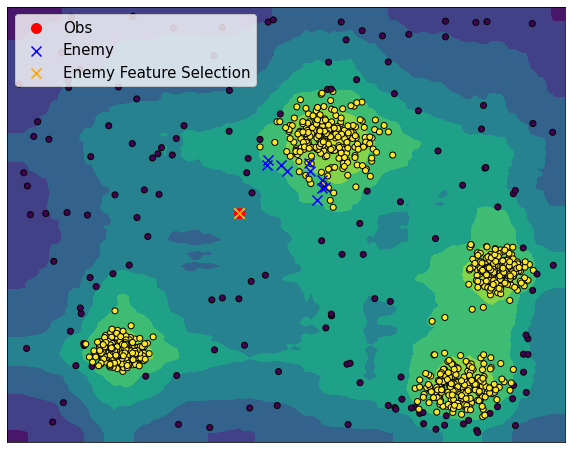

In [89]:
clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.fit(X_similar)
y_pred = clf.predict(X_similar)

idx = np.argwhere(y_pred==-1)[40] # first_outliers 
obs = X_similar[idx][0]

radius = 0.5
step = 0.5
N = 300

GS = GrowingSpheres(clf, 2, N)
GS.predict(obs)
SL = GS.generate_spherical_layer(radius, radius + step)

fig, ax = plt.subplots(figsize=(10, 8))
visualize((X_similar,y_pred), clf, obs, ax=ax)